In [125]:
import numpy as np
import math
import pandas as pd

import importlib

import gerg2 as gerg
importlib.reload(gerg)
import pr_z_v10 as pr_z
importlib.reload(pr_z)

from tabulate import tabulate as tabulate
from scipy.optimize import minimize
degF2R = 459.67

from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rcParams
import numpy as np
import matplotlib.cm as cm # matplotlib's color map library
from scipy.interpolate import griddata
R, mwAir, degF2R = 10.731577089016, 28.97, 459.67

In [32]:
xi = [0.571885113, 0.087644452, 0.069725338, 0.027734914, 0.027734914, 0.022064446, 0.022064446, 0.035106636, 0.027929002, 0.022218852, 0.017676155, 0.068215732]
gerg.gerg_props2(2500, 180, xi, co2=0, h2s=0, n2=0, h2=0, iFlag = 1)

Inputs-----
Temperature [K]:                   355.3722222222222
Pressure [kPa]:                    17236.899999999998
Outputs-----
Molar mass [g/mol]:                41.62708448615913
Molar density [mol/l]:             9.752236124940126
Pressure [kPa]:                    17236.900000009187
Compressibility factor:            0.5981867662805338
d(P)/d(rho) [kPa/(mol/l)]:         8532.97140585428
d^2(P)/d(rho)^2 [kPa/(mol/l)^2]:   5593.138581185984
d(P)/d(T) [kPa/K]:                 299.20865253847614
Energy [J/mol]:                    -8199.782371636178
Enthalpy [J/mol]:                  -6432.300557293315
Entropy [J/mol-K]:                 -36.49882768475048
Isochoric heat capacity [J/mol-K]: 81.49671371781027
Isobaric heat capacity [J/mol-K]:  120.7000536458484
Speed of sound [m/s]:              550.9926824969688
Gibbs energy [J/mol]:              6538.368945542428
Joule-Thomson coefficient [K/kPa]: 0.00023598027052140833
Isentropic exponent:               7.150109664833367


In [123]:
def lee_kesler_tc_pc(xi, co2, h2s, n2): # From SPE Monograph, pp 91/240
    components = ['CO2', 'H2S', 'N2', 'C1', 'C2', 'C3', 'I-C4', 'N-C4', 'I-C5', 'N-C5', 'N-C6', 'N-C7', 'N-C8', 'N-C9', 'N-C10']
    MW = np.array([44.01, 34.082, 28.014, 16.043, 30.07, 44.097, 58.123, 58.123, 72.15, 72.15, 86.177, 100.204, 114.231, 128.258, 142.285])
    Tc = np.array([547.416, 672.12, 227.16, 343.008, 549.576, 665.694, 734.13, 765.216, 828.702, 845.46, 913.68, 972.36, 1023.66, 1070.28, 1111.86])
    Pc = np.array([1069.508, 1299.973, 492.838, 667.029, 706.624, 616.12, 527.937, 550.563, 490.373, 488.777, 438.739, 397.403, 361.144, 332.136, 306.03])
    ACF = np.array([0.225, 0.09, 0.037, 0.011, 0.099, 0.152, 0.186, 0.2, 0.229, 0.252, 0.3, 0.35, 0.399, 0.445, 0.49])
    VC = np.array([1.50686, 1.56981, 1.44326, 1.57942, 2.33069, 3.20369, 4.20805, 4.08471, 4.93849, 4.98174, 5.89479, 6.8559, 7.88108, 8.89025, 9.99552])

    xi =np.array(xi)/np.sum(xi)
    xi = xi*(1-co2-h2s-n2)
    z = np.array([co2, h2s, n2]+list(xi))

    Vcl = 0
    for i in range(len(MW)):
        for j in range(len(MW)):
            Vcl += 1/8 * z[i]*z[j]*(VC[i]**(1/3) + VC[j]**(1/3))**3
    Tcl = 0
    for i in range(len(MW)):
        for j in range(len(MW)):
            Tcl += 1/(8*Vcl) * z[i]*z[j]*(Tc[i]*Tc[j])**(1/2)*(VC[i]**(1/3) + VC[j]**(1/3))**3

    wl = np.sum(z*ACF)
    Zcl = 0.2905 - 0.085*wl
    Pcl = Zcl * R * Tcl / Vcl
    return Tcl, Pcl
    

In [126]:
# Find critical temperature, where dP/dRho = d2P/dRho2 = 0
def crit_residuals(x):
    t, p = x
    dp_drho, d2p_drho2 = gerg.gerg_dp_dp2(p, t - degF2R, zi, co2=0, h2s=0, n2=0, h2=0, iFlag = 1)
    return (abs(dp_drho)+abs(d2p_drho2))

def crit_residuals2(x):
    t, p = x
    dp_drho, d2p_drho2 = gerg.gerg_dp_dp2(p, t - degF2R, zi, co2=0, h2s=0, n2=0, h2=0, iFlag = 1)
    return dp_drho, d2p_drho2
    
mw_hcs = [16.043, 27.91, 34.51, 41.63] # All synthetic mixtures
xis = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.708204332, 0.098093421, 0.065117425, 0.021613473, 0.021613473, 0.014347687, 0.014347687, 0.019048871, 0.012645226, 0.008394289, 0.005572387, 0.011001729],
       [0.630537317, 0.096961472, 0.071518722, 0.026376083, 0.026376083, 0.019454982, 0.019454982, 0.028699966, 0.021169077, 0.015614298, 0.011517097, 0.032319921],
       [0.571885113, 0.087644452, 0.069725338, 0.027734914, 0.027734914, 0.022064446, 0.022064446, 0.035106636, 0.027929002, 0.022218852, 0.017676155, 0.068215732]]
options = {'verbose': 0, 'gtol': 1e-6, 'xtol': 1e-6, 'maxiter': 10000}
sols = []
for i, mw_hc in enumerate(mw_hcs):
    zi = xis[i]
    #tc_guess, pc_guess = pr_z.tc_pc(mw_hc/28.97) # First guess 
    tc_guess, pc_guess = lee_kesler_tc_pc(zi, 0, 0, 0)
    
    sol = minimize(crit_residuals, [tc_guess, pc_guess], bounds = ((0.75*tc_guess, 1.25*tc_guess), (0.75*pc_guess, 1.25*pc_guess)), method = 'trust-constr', options=options)
    tc, pc = sol.x
    print(mw_hc, tc, pc, sol.fun, tc_guess, pc_guess, sol.nit)
    sols.append([tc, pc])


16.043 343.6783246931813 674.8203279040133 4.193722917100929 343.00800000000004 674.863955121382 234
27.91 474.4063746772257 647.8948182100653 79.79271141850896 485.5369688556304 677.3035189776824 303
34.51 534.9072777471977 605.1066156429241 60.608649995266674 548.7898063019243 654.0642908899845 240
41.63 599.6623835114908 584.0020132182011 126.76856304735061 608.7178981327803 623.4933424017122 1347


In [119]:
# Find critical temperature, where dP/dRho = d2P/dRho2 = 0  
mw_hc = 41.63
zi = [0.571885113, 0.087644452, 0.069725338, 0.027734914, 0.027734914, 0.022064446, 0.022064446, 0.035106636, 0.027929002, 0.022218852, 0.017676155, 0.068215732]

degRs = np.arange(590, 615, 0.1)#(0.75*tc_guess, 1.25*tc_guess, 2)
psias = np.arange(550, 650, 0.1)#(0.75*pc_guess, 1.25*pc_guess, 2)
xi,yi = np.meshgrid(degRs,psias)

x, y, err = [], [], []
dp_drhos, d2p_drho2s = [], []
for degR in degRs:
    for psia in psias:
        dp_drho, d2p_drho2 = crit_residuals2([degR, psia])
        dp_drhos.append(dp_drho)
        d2p_drho2s.append(d2p_drho2)
        x.append(degR)
        y.append(psia)

sum_err = np.abs(dp_drho)+np.abs(d2p_drho2s)

# interpolate
zi1 = griddata((x,y), dp_drhos, (xi,yi),method='linear')
zi2 = griddata((x,y), d2p_drho2s, (xi,yi),method='linear')
zi3 = griddata((x,y), sum_err, (xi,yi),method='linear')



In [120]:
np.min(zi3)

299.9499513806665

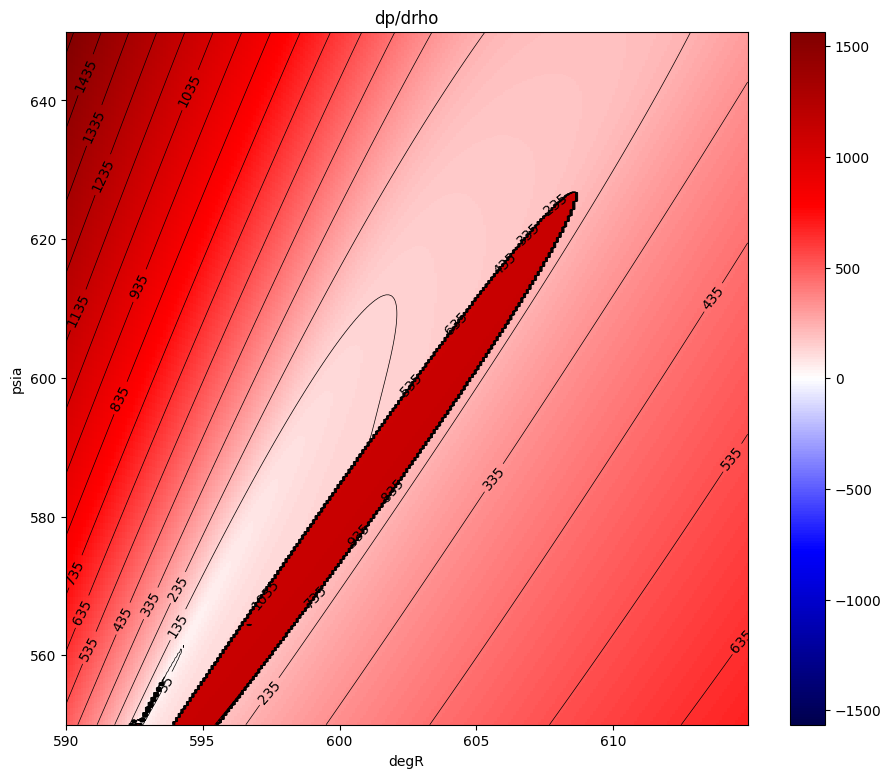

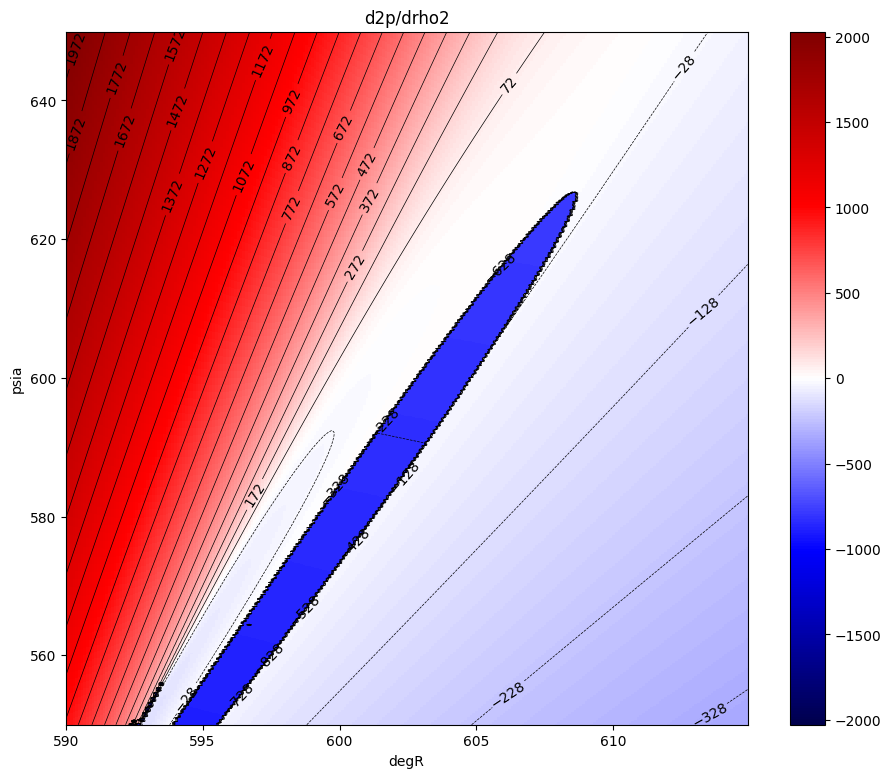

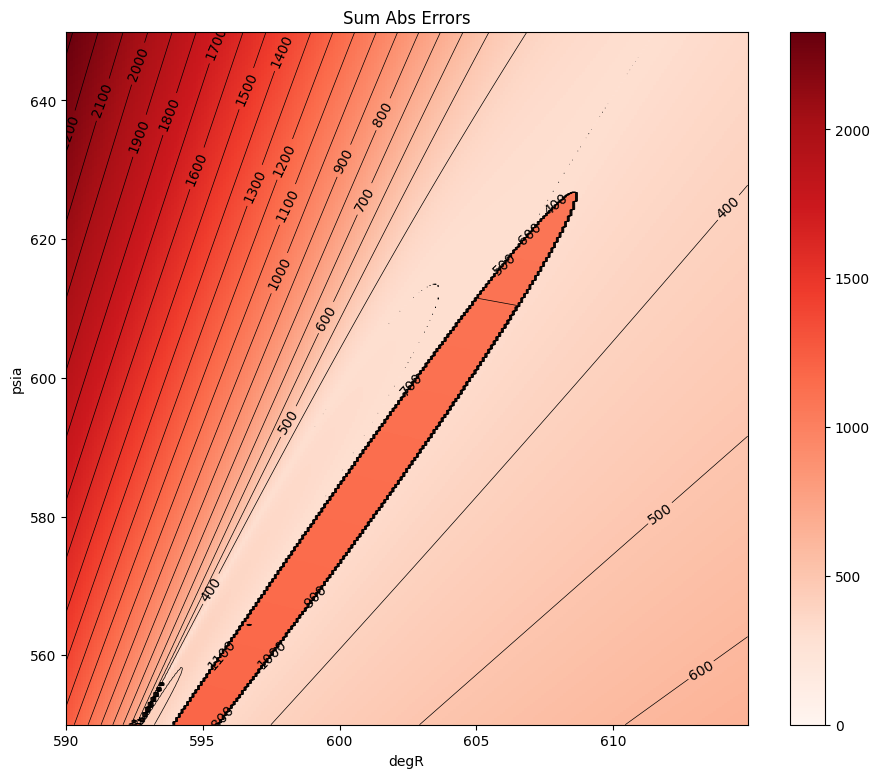

In [121]:
rcParams['figure.figsize'] = 11, 9
fig, ax = plt.subplots()
max_val = abs(np.min(zi1))
if np.max(zi1) > max_val:
    max_val = np.max(zi1) 
c = ax.pcolormesh(xi, yi, zi1, cmap='seismic', vmin=-max_val, vmax=max_val)
levels = np.arange(-max_val, max_val, 100)
CS = ax.contour(xi, yi, zi1, levels=levels, linewidths=0.5, colors='k')
ax.clabel(CS, inline=True, fontsize=10)

ax.set_title('dp/drho')
# set the limits of the plot to the limits of the data
ax.axis([xi.min(), xi.max(), yi.min(), yi.max()])
ax.set_ylabel('psia')
ax.set_xlabel('degR')
#ax.set_ylim(0, 15000)
#ax.set_xlim(60, 300)

fig.colorbar(c, ax=ax)
plt.show()

rcParams['figure.figsize'] = 11, 9
fig, ax = plt.subplots()
max_val = abs(np.min(zi2))
if np.max(zi2) > max_val:
    max_val = np.max(zi2) 
c = ax.pcolormesh(xi, yi, zi2, cmap='seismic', vmin=-max_val, vmax=max_val)
levels = np.arange(-max_val, max_val, 100)
CS = ax.contour(xi, yi, zi2, levels=levels, linewidths=0.5, colors='k')
ax.clabel(CS, inline=True, fontsize=10)

ax.set_title('d2p/drho2')
# set the limits of the plot to the limits of the data
ax.axis([xi.min(), xi.max(), yi.min(), yi.max()])
ax.set_ylabel('psia')
ax.set_xlabel('degR')
#ax.set_ylim(0, 15000)
#ax.set_xlim(60, 300)

fig.colorbar(c, ax=ax)
plt.show()

rcParams['figure.figsize'] = 11, 9
fig, ax = plt.subplots()
max_val = abs(np.max(zi3))
c = ax.pcolormesh(xi, yi, zi3, cmap='Reds', vmin=0, vmax=max_val)
levels = np.arange(0, max_val, 100)
CS = ax.contour(xi, yi, zi3, levels=levels, linewidths=0.5, colors='k')
ax.clabel(CS, inline=True, fontsize=10)

ax.set_title('Sum Abs Errors')
# set the limits of the plot to the limits of the data
ax.axis([xi.min(), xi.max(), yi.min(), yi.max()])
ax.set_ylabel('psia')
ax.set_xlabel('degR')
#ax.set_ylim(0, 15000)
#ax.set_xlim(60, 300)

fig.colorbar(c, ax=ax)
plt.show()


In [8]:
base_chr = 'RealGas'
fileloc = 'HC_BIPS_v10_GERG'

mwAir = 28.97
#                 26     33    42
mw_hcs = [16.043, 27.91, 34.51, 41.63] # All synthetic mixtures
names=['lean_gas','leanmid_gas', 'mid_gas', 'rich_gas' ]
xis = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.708204332, 0.098093421, 0.065117425, 0.021613473, 0.021613473, 0.014347687, 0.014347687, 0.019048871, 0.012645226, 0.008394289, 0.005572387, 0.011001729],
       [0.630537317, 0.096961472, 0.071518722, 0.026376083, 0.026376083, 0.019454982, 0.019454982, 0.028699966, 0.021169077, 0.015614298, 0.011517097, 0.032319921],
       [0.571885113, 0.087644452, 0.069725338, 0.027734914, 0.027734914, 0.022064446, 0.022064446, 0.035106636, 0.027929002, 0.022218852, 0.017676155, 0.068215732]]

degfs = [60, 90, 120, 150, 180, 220, 250, 280]
psias = [1500, 2000, 2500, 5000, 7500, 10000, 15000]
hc_fractions = [0.8, 0.6, 0.4, 0.2]

compnames = ['CO2', 'H2S', 'N2', 'H2', 'Gas']
comp_dic = {0: 'CO2', 1: 'H2S', 2: 'N2', 3: 'H2'}
all_degfs, all_sgs, all_psias, all_zs, all_comps = [[] for x in range(5)]

gerg_comps = []
for j in range(len(xis)):
    mw_hc = mw_hcs[j]
    name = names[j]
    xi = xis[j]
    for i in range(len(compnames)-1):   
        out_str = 'DEFINE MW '+str(mw_hc)+'\n'
        for frac in hc_fractions:
            if i == 0:
                co2, h2s, n2, h2 = 1-frac, 0, 0, 0
            if i == 1:
                co2, h2s, n2, h2 = 0, 1-frac, 0, 0
            if i == 2:
                co2, h2s, n2, h2 = 0, 0,  1-frac, 0
            if i == 3:
                co2, h2s, n2, h2 = 0, 0,  0, 1-frac
            comps = [co2, h2s, n2, h2, frac]
            
            sg = (frac * mw_hc + co2 * 44.01 + h2s * 34.082 + n2 * 28.014 + h2 * 2.016) / mwAir
            
            for degf in degfs:
                zs = []
                for psia in psias:
                    all_degfs.append(degf)
                    all_sgs.append(sg)
                    all_psias.append(psia)
                    all_comps.append([co2, h2s, n2, h2])
                    gerg_comps.append(np.array(xi)*(1-co2-h2s-n2-h2))
                    z = gerg.gerg_z2(psia, degf, xi, co2, h2s, n2, h2, iFlag = 1)
                    all_zs.append(z)
                    zs.append(z)
                    
                out_str += 'DEFINE degR '+str(degf+459.67)+'\n\n'
                out_str += 'CHARACTERIZATION "CHR_'+str(degf)+'_'+str(frac)+'_'+comp_dic[i]+'" BASE "'+base_chr+'"\n'
                header = ['COMPONENT', 'MW', 'TC,R', 'PC,PSIA', 'AF', 'VTRAN', 'A', 'B', 'AMOD', 'BMOD']
                rows = []
                for c in range(len(compnames)):
                    rows.append([compnames[c], '', '', '', '', '', '', '', '', ''])
                rows[-1][1] = round(mw_hc, 4)
    
                out_str += tabulate(rows, header)
                out_str += '\nEND\n\n'
                
                out_str += 'DEFINE degR_Slope CO2_degR_Slope, DEFINE MW_Slope CO2_MW_Slope, DEFINE Intcpt CO2_Intcpt, DEFINE Inert CO2\n'
                out_str += 'INCLUDE bips_calc.inc\n\n'
                
                out_str += 'DEFINE degR_Slope H2S_degR_Slope, DEFINE MW_Slope H2S_MW_Slope, DEFINE Intcpt H2S_Intcpt, DEFINE Inert H2S\n'
                out_str += 'INCLUDE bips_calc.inc\n\n'
                
                out_str += 'DEFINE degR_Slope N2_degR_Slope, DEFINE MW_Slope N2_MW_Slope, DEFINE Intcpt N2_Intcpt, DEFINE Inert N2\n'
                out_str += 'INCLUDE bips_calc.inc\n\n'
                
                out_str += 'DEFINE degR_Slope H2_degR_Slope, DEFINE MW_Slope H2_MW_Slope, DEFINE Intcpt H2_Intcpt, DEFINE Inert H2\n'
                out_str += 'INCLUDE bips_calc.inc\n\n'
                temp = degf
            
                ## Inert:Inert BIP Pairs                                                                                                   
                #slopes = [[-0.000879210909090909, -0.00130965, 0.00118182785714286, -0.00150498, 0.00461018571428571, 0.000235450357142857],                                
                #          [0.00009085, 0.000541365245623941, 0.00135899363636364, 0.00103136527385658, 0.00112685210526316, 0.000149872727272727]]                                    
                #intcpts = [[0.239517381818182, -0.085784, 0.203866711904762, 0.85241, 0.400074571428572, 0.204373053571429],                                   
                #           [0.0880919666666667, -0.247960272896669, 0.172206318181818, 0.601450271597967, 0.822955005263158, 0.220908090909091]]                               
                #evals = [np.max, np.max, np.max, np.max, np.min, np.min]                                                                  
                #pairs = ['H2S with CO2', 'CO2 with N2', 'H2S WITH N2', 'CO2 with H2', 'H2S with H2', 'N2 with H2']                       
                #inert_bips = [evals[i]([slopes[0][i]*temp + intcpts[0][i], slopes[1][i]*temp + intcpts[1][i]]) for i in range(len(pairs))]
                #
                #for p, pair in enumerate(pairs):                                                                                          
                #    out_str += 'REPLACE BIP of '+pair+' by '+str(inert_bips[p])+'\n'   
                    
                #BIP_HC = max(0.000160492*temp + 0.056787492, 1/(0.040933216*temp + 2.454878276)) 
                #BIP_CN = 1/(-0.061940854*temp + -0.494913095)                     
                #BIP_HN = -0.836144851 + (temp * 2.80825315) / (348.2693873 + temp)

                #out_str += 'REPLACE BIP of H2S with CO2 by '+str(BIP_HC)+'\n'
                #out_str += 'REPLACE BIP of CO2 with N2 by '+str(BIP_CN)+'\n'
                #out_str += 'REPLACE BIP of H2S with N2 by '+str(BIP_HN)+'\n\n'
                
                out_str += 'REPLACE BIP of CO2 with H2S by CO2_H2S\n'
                out_str += 'REPLACE BIP of CO2 with N2 by CO2_N2\n'
                out_str += 'REPLACE BIP of CO2 with H2 by CO2_H2\n'
                out_str += 'REPLACE BIP of H2S with N2 by H2S_N2\n'
                out_str += 'REPLACE BIP of H2S with H2 by H2S_H2\n'
                out_str += 'REPLACE BIP of N2 with H2 by N2_H2\n\n'
            
                
                out_str += '\nINCLUDE '+name+'_init.inc\n\n'   

                out_str += 'MIX FEED\n'
                
                rows = []
                for c in range(len(compnames)):
                    rows.append([compnames[c], comps[c]])
                out_str += tabulate(rows)
                out_str += '\nEND\n\n'
            
                out_str += 'CCE ID "'+str(degf)+'_'+str(frac)+'_'+comp_dic[i]+'"\n'
    
                exp_df = pd.DataFrame()
                
                exp_df['TEMP (F)']= [degf for z in zs]
                exp_df['PRES (psia)']= psias
                exp_df['Z']= zs
    
                out_str += tabulate(exp_df, headers='keys', showindex='never', numalign='left')
                out_str += '\nEND\n\n'
        
        with open('.\\'+fileloc+'\\'+name+comp_dic[i]+'.inc', 'w') as file:
            file.write(out_str)


exp_df = pd.DataFrame()
exp_df['psia']= all_psias
exp_df['Z']= all_zs
exp_df['degf']= all_degfs
exp_df['sg']= all_sgs
exp_df['co2']= [comp[0] for comp in all_comps]
exp_df['h2s']= [comp[1] for comp in all_comps]
exp_df['n2']= [comp[2] for comp in all_comps]
exp_df['h2']= [comp[3] for comp in all_comps]
exp_df['Sample']= ['GERG' for z in all_zs]
exp_df['Source']= ['GERG' for z in all_zs]  
exp_df['C1']= [x[0] for x in gerg_comps] 
exp_df['C2']= [x[1] for x in gerg_comps]
exp_df['C3']= [x[2] for x in gerg_comps]
exp_df['iC4']= [x[3] for x in gerg_comps]
exp_df['nC4']= [x[4] for x in gerg_comps]
exp_df['iC5']= [x[5] for x in gerg_comps]
exp_df['nC5']= [x[6] for x in gerg_comps]
exp_df['C6']= [x[7] for x in gerg_comps]
exp_df['C7']= [x[8] for x in gerg_comps]
exp_df['C8']= [x[9] for x in gerg_comps]
exp_df['C9']= [x[10] for x in gerg_comps]
exp_df['C10']= [x[11] for x in gerg_comps]

In [9]:
exp_df.to_excel('GERG_Synthetic_Data_v10.xlsx', index=False)

## Make Inert:Inert combinations

In [34]:
base_chr = 'RealGas'
fileloc = 'HC_BIPS_v10_GERG'

mwAir = 28.97
xi = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
degfs = [60, 90, 120, 150, 180, 220, 250, 280]
psias = [1500, 2000, 2500, 5000, 7500, 10000, 15000]

compnames = ['CO2', 'H2S', 'N2', 'H2']
all_degfs, all_sgs, all_psias, all_zs, all_comps = [[] for x in range(5)]

for j in range(len(compnames)-1):
    for i in range(j+1, len(compnames)): 
        yi = 4*[0]
        yi[i] = 0.5
        yi[j] = 0.5
        sg = (frac * mw_hc + yi[0] * 44.01 + yi[1] * 34.082 + yi[2] * 28.014 + yi[3] * 2.016) / mwAir
        out_str = 'TITLE "50:50 '+compnames[j]+' with '+compnames[i]+'"\n\n'    
        for degf in degfs:                                                                                                                                                         
            zs = []                                                                                                                                                                
            for psia in psias:                                                                                                                                                     
                all_degfs.append(degf)                                                                                                                                             
                all_sgs.append(sg)                                                                                                                                                 
                all_psias.append(psia)                                                                                                                                             
                all_comps.append([co2, h2s, n2, h2])                                                                                                                               
                z = gerg.gerg_z2(psia, degf, xi, yi[0], yi[1], yi[2], yi[3], iFlag = 1)                                                                                                      
                all_zs.append(z)                                                                                                                                                   
                zs.append(z)                                                                                                                                                       
                                                                                                                                                                                   
            out_str += 'DEFINE degR '+str(degf+459.67)+'\n\n'                                                                                                                      
            out_str += 'CHARACTERIZATION "CHR_'+str(degf)+'_'+compnames[j]+'_'+compnames[i]+'" BASE "'+base_chr+'"\n'                                                                  
            header = ['COMPONENT', 'MW', 'TC,R', 'PC,PSIA', 'AF', 'VTRAN', 'A', 'B', 'AMOD', 'BMOD']                                                                               
            rows = []                                                                                                                                                              
            for c in range(len(compnames)):                                                                                                                                        
                rows.append([compnames[c], '', '', '', '', '', '', '', '', ''])                                                                                                    
                                                                                                                                        
                                                                                                                                                                                   
            out_str += tabulate(rows, header)                                                                                                                                      
            out_str += '\nEND\n\n'                                                                                                                                                                                                                                                
                                                                                                                                                                                   
            out_str += 'REPLACE BIP of CO2 with H2S by CO2_H2S\n'
            out_str += 'REPLACE BIP of CO2 with N2 by CO2_N2\n'
            out_str += 'REPLACE BIP of CO2 with H2 by CO2_H2\n'
            out_str += 'REPLACE BIP of H2S with N2 by H2S_N2\n'
            out_str += 'REPLACE BIP of H2S with H2 by H2S_H2\n'
            out_str += 'REPLACE BIP of N2 with H2 by N2_H2\n\n'                                                                                                                                                                                                                                                                                                                                                                                                                     
                                                                                                                                                                                   
            out_str += 'MIX FEED\n'                                                                                                                                                
                                                                                                                                                                                   
            rows = []                                                                                                                                                              
            for c in range(len(compnames)):                                                                                                                                        
                rows.append([compnames[c], yi[c]])                                                                                                                              
            out_str += tabulate(rows)                                                                                                                                              
            out_str += '\nEND\n\n'                                                                                                                                                 
                                                                                                                                                                                   
            out_str += 'CCE ID "'+compnames[j]+'_'+compnames[i]+'_'+str(degf)+'"\n'                                                                                                    
                                                                                                                                                                                   
            exp_df = pd.DataFrame()                                                                                                                                                
                                                                                                                                                                                   
            exp_df['TEMP (F)']= [degf for z in zs]                                                                                                                                 
            exp_df['PRES (psia)']= psias                                                                                                                                           
            exp_df['Z']= zs  
            exp_df['Wt']= '?inert_wts?'
                                                                                                                                                                                   
            out_str += tabulate(exp_df, headers='keys', showindex='never', numalign='left')                                                                                        
            out_str += '\nEND\n\n'                                                                                                                                                 
                                                                                                                                                                                       
        with open('.\\'+fileloc+'\\'+compnames[j]+'_'+compnames[i]+'.inc', 'w') as file:                                                                                                            
            file.write(out_str)   
            print(compnames[j]+'_'+compnames[i]+'.inc')
                                                                                                                                                                                       



CO2_H2S.inc
CO2_N2.inc
CO2_H2.inc
H2S_N2.inc
H2S_H2.inc
N2_H2.inc


## And make data for pure paraffins

In [55]:
coefic_pc = [0.00514195, 1.50107866]
coefic_tc = [0.00244823, 0.30153678]
base_chr = 'RealGas'
fileloc = 'GERG_Pure'
hc_names = ['C1', 'C2', 'C3', 'I-C4', 'N-C4', 'I-C5', 'N-C5', 'N-C6', 'BENZENE', 'N-C7', 'C-C7', 'N-C8', 'N-C9', 'N-C10']

names=['lean_gas','leanmid_gas', 'mid_gas', 'leanmid_gas_aromat','mid_gas_aromat']#, 'rich_gas' ]
xis = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.831940685, 0.045074732, 0.024596917, 0.00670825, 0.012828057, 0.007061316, 0.00670825, 0.010945039, 0, 0.008189118, 0, 0.006202202, 0.004697369, 0.035048066],
       [0.663296918, 0.104190445, 0.065873145, 0.011576716, 0.021359857, 0.008315669, 0.00766346, 0.017935757, 0, 0.027555845, 0, 0.011739768, 0.00978314, 0.050709278],
       [0.831940685, 0.045074732, 0.024596917, 0.00670825, 0.012828057, 0.007061316, 0.00670825, 0, 0.010945039, 0, 0.008189118, 0.006202202, 0.004697369, 0.035048066],
       [0.663296918, 0.104190445, 0.065873145, 0.011576716, 0.021359857, 0.008315669, 0.00766346, 0, 0.017935757, 0, 0.027555845, 0.011739768, 0.00978314, 0.050709278]]
# [0.336259298, 0.159219833, 0.160102696, 0.034431669, 0.087027998, 0.039688258, 0.042935571, 0.050343505, 0, 0.03731366, 0, 0.023674944, 0.005987234, 0.023015333] # Rich
degfs = [60, 90, 120, 150, 180, 220, 250, 280]
psias = [1500, 2000, 2500, 5000, 7500, 10000, 15000]

pressures = {} # Set pressure ranges to fit over to avoid issues with condensate
for degf in degfs:
    pressures['lean_gas'+str(degf)] = psias
    pressures['leanmid_gas'+str(degf)] = psias[3:]
    pressures['mid_gas'+str(degf)] = psias[3:]


hc_fractions = [1.0]
all_degfs, all_sgs, all_psias, all_zs, all_comps = [[] for x in range(5)]

for j in range(len(names)):
    name = names[j]
    xi = xis[j]
    #xi = [x/sum(xi) for x in xi]
    for i in range(3):   
        out_str = 'TITLE '+name+'\n'
        for frac in hc_fractions:
            
            out_str += 'MIX FEED\n'
                
            rows = []
            for c in range(len(hc_names)):
                rows.append([hc_names[c], xi[c]])
            out_str += tabulate(rows)
            out_str += '\nEND\n\n'
                
            for degf in degfs:
                
                zs = []
                psia_name = name+str(degf)
                psia_name = psia_name.replace('_aromat','')
                for psia in pressures[psia_name]:
                    all_degfs.append(degf)
                    all_sgs.append(sg)
                    all_psias.append(psia)
                    all_comps.append([co2, h2s, n2])
                    if 'aromat' in name:
                        z = ''
                    else:
                        xj = xi[:8]+[xi[9]]+xi[11:]
                        z = gerg.gerg_z2(psia, degf, xj, 0, 0, 0, iFlag = 1)
                    all_zs.append(z)
                    zs.append(z)
                
                
            
                out_str += 'CCE ID "'+str(degf)+'_'+name+'"\n'
    
                exp_df = pd.DataFrame()
                
                exp_df['TEMP (F)']= [degf for z in zs]
                exp_df['PRES (psia)']= pressures[psia_name]
                exp_df['Z']= zs
                exp_df['LMF']= ['' for z in zs]
    
                out_str += tabulate(exp_df, headers='keys', showindex='never', numalign='left')
                out_str += '\nEND\n\n'
        
        with open('.\\'+fileloc+'\\'+name+'.inc', 'w') as file:
            file.write(out_str)


exp_df = pd.DataFrame()
exp_df['psia']= all_psias
exp_df['Z']= all_zs
exp_df['degf']= all_degfs
exp_df['sg']= all_sgs
exp_df['co2']= [comp[0] for comp in all_comps]
exp_df['h2s']= [comp[1] for comp in all_comps]
exp_df['n2']= [comp[2] for comp in all_comps]
exp_df['Sample']= ['GERG' for z in all_zs]
exp_df['Source']= ['GERG' for z in all_zs]          
            


In [51]:
psia_name.replace('aromat','')

'lean_mid_60'

In [41]:
xi

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]